# TikTok Project 


# Classify videos using machine learning and EDA

Imports important libraries

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer

# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, precision_score, \
recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance

### Load Dataset

In [2]:
# Load dataset into dataframe
data = pd.read_csv("tiktok_dataset.csv")



### Analyze the data


Inspect the first five rows of the dataframe.

In [3]:
# Display first few rows
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


Get the number of rows and columns in the dataset.

In [4]:
# Get number of rows and columns
data.shape

(19382, 12)

Get basic information about the dataset.

In [5]:
# Get basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


Generate basic descriptive statistics about the dataset.

In [6]:
# Generate basic descriptive stats
data.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


Check and handle missing values

In [7]:
# Check for missing values
data.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

There are very few missing values consider we have 19382 row. So, in this case we will drop the missing value

In [8]:
# Drop rows with missing values
data = data.dropna(axis=0)

Check for and handle duplicates

In [9]:
# Check for duplicates
data.duplicated().sum()

0

Check class balance.

In [10]:
# Check class balance
data["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

<AxesSubplot:xlabel='claim_status', ylabel='count'>

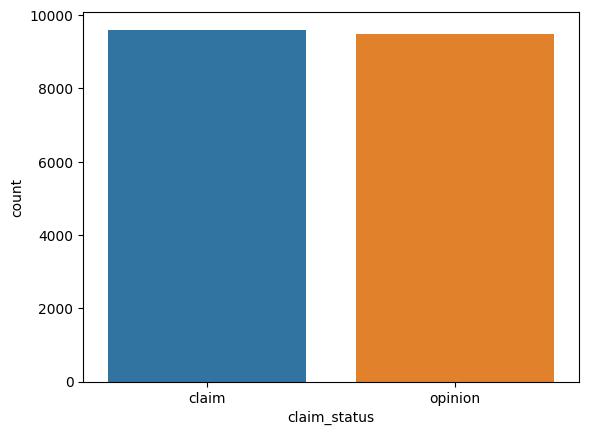

In [11]:
sns.countplot(x= data['claim_status'])

The claim status is quite balance with approximately 50.3% of the dataset represents claims and around 49.7% represents opinions

<AxesSubplot:xlabel='verified_status', ylabel='count'>

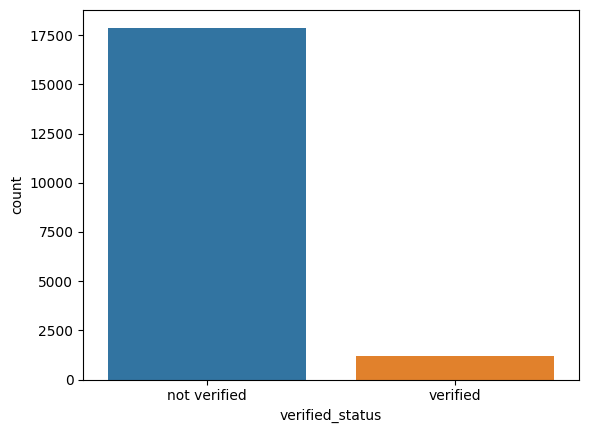

In [12]:
sns.countplot(x=data['verified_status'])

Most of the people not verified their tiktok account

<AxesSubplot:xlabel='author_ban_status', ylabel='count'>

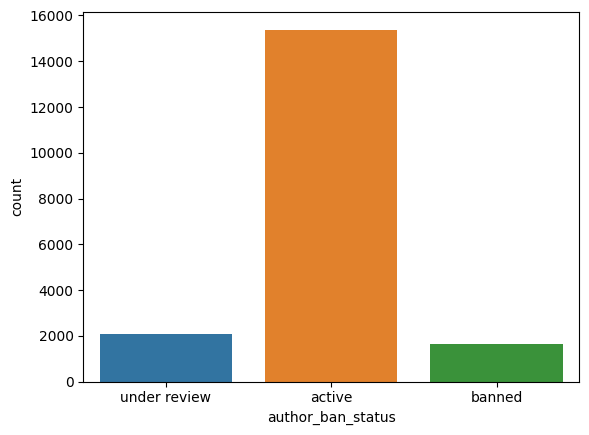

In [13]:
sns.countplot(x=data['author_ban_status'])

This show that only few acount that got banned and under review compaared to active account.

####  Feature engineering


Extract the length (character count) of each `video_transcription_text` to create a new feature column that count text length.

In [14]:
data['text_length'] = data['video_transcription_text'].str.len()
data.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


Calculate the average `text_length` for claims and opinions.



In [15]:
data[['claim_status', 'text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


Visualize the distribution of `text_length` for claims and opinions using a histogram.

Text(0.5, 1.0, 'Distribution of video text length for claim staatus')

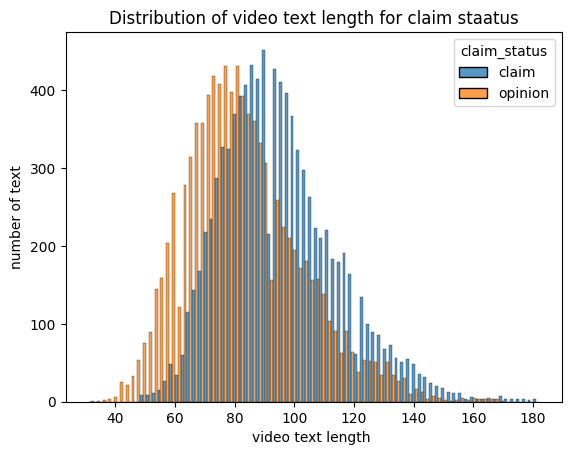

In [16]:
# Visualize the distribution of `text_length` for claims and opinions
# Create two histograms in one plot

sns.histplot(data=data, stat="count", multiple="dodge", x="text_length",hue="claim_status", legend=True)
plt.xlabel("video text length ")
plt.ylabel("number of text")
plt.title("Distribution of video text length for claim staatus")

Letter count distributions for both claims and opinions are normal distribution.

**Feature selection and transformation**

Drop some columns that we not going to use.

In [17]:

df = data.copy()
# Drop unnecessary columns
df = df.drop(['#', 'video_id'], axis=1)

Encode catgorical variables.

In [18]:

# Encode target variable
df['claim_status'] = df['claim_status'].map({'opinion': 0, 'claim': 1})
# Dummy encode remaining categorical values
df = pd.get_dummies(df,columns=['verified_status', 'author_ban_status'], drop_first=True)

Text exact to create a matrix of token counts by using Count Vectorizer

In [19]:
count_vec = CountVectorizer(ngram_range=(2, 3),
                            max_features=15,
                            stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [20]:
count_data = count_vec.fit_transform(df['video_transcription_text']).toarray()

# Place the numerical representation of `video_transcription_text` from training set into a dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

#cotcat to the X_train data set
data_final = pd.concat([df.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

# Display first few rows
data_final.head()

,claim_status,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,...,friend read,internet forum,learned media,learned news,media claim,news claim,point view,read media,social media,willing wager
0,1,59,343296.0,19425.0,241.0,1.0,0.0,97,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,32,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,31,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,25,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,19,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,...,0,0,0,0,0,0,0,0,0,0


### Split the data

In [21]:
y = data_final['claim_status']
X = data_final.drop(['claim_status'], axis=1)

Create train/validate/test sets

Split data into training and testing sets

In [22]:
# Split the data into training and testing sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, test_size=0.20, random_state=12)

In [23]:
# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, test_size=0.25, random_state=12)

Confirm that the dimensions of the training, validation, and testing sets are in alignment.

In [24]:
# Get shape of each training, validation, and testing set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 25), (3817, 25), (3817, 25), (11450,), (3817,), (3817,))

## Build models 

###  Random forest find the best hyper parameter 


In [25]:
# Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [3, None],
             'max_features': [0.3, 0.6],
            #  'max_features': 'auto'
             'max_samples': [0.7,0.8],
             'min_samples_leaf': [1,2],
             'min_samples_split': [2,3],
             'n_estimators': [75,100],
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [26]:
%%time
rf_cv.fit(X_train, y_train)
print("best score: ",rf_cv.best_score_)
print("best parameter: ", rf_cv.best_params_)

best score:  0.9949247149710491
best parameter:  {'max_depth': None, 'max_features': 0.6, 'max_samples': 0.7, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
CPU times: total: 2min 21s
Wall time: 2min 22s


### XGBoost find the best hyper parameter 

In [27]:
# Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

# Create a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
             'min_child_weight': [3,4,5],
             'learning_rate': [0.01, 0.1],
             'n_estimators': [300, 500]
             }

# Define a dictionary of scoring metrics to capture
scoring = {'accuracy', 'precision', 'recall', 'f1'}

# Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')

Note this cell might take several minutes to run.

In [28]:
%%time
xgb_cv.fit(X_train, y_train)
print("best score: ",xgb_cv.best_score_)
print("best parameter: ", xgb_cv.best_params_)

best score:  0.9905498021153661
best parameter:  {'learning_rate': 0.1, 'max_depth': 8, 'min_child_weight': 3, 'n_estimators': 300}
CPU times: total: 7min 58s
Wall time: 52.4 s


### Build models and predict

#### **Random forest**

In [29]:
# Use the random forest "best estimator" model to get predictions on the validation set
y_pred = rf_cv.best_estimator_.predict(X_val)

Display the predictions on the validation set.

In [30]:
# Display the predictions on the validation set
y_pred

array([1, 0, 0, ..., 1, 0, 1], dtype=int64)

Create a confusion matrix to visualize the results of the classification model.

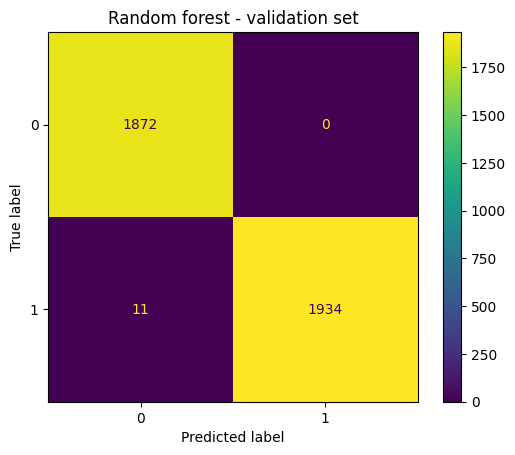

In [31]:
# Compute values for confusion matrix
rf_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=None)

# Plot confusion matrix
rf_disp.plot()

# Display plot
plt.title('Random forest - validation set');
plt.show()

In [32]:
# Create a classification report
# Create classification report for random forest model
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      1.00      1872
       claim       1.00      0.99      1.00      1945

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



#### **XGBoost**

In [33]:
#Evaluate XGBoost model
y_pred = xgb_cv.best_estimator_.predict(X_val)

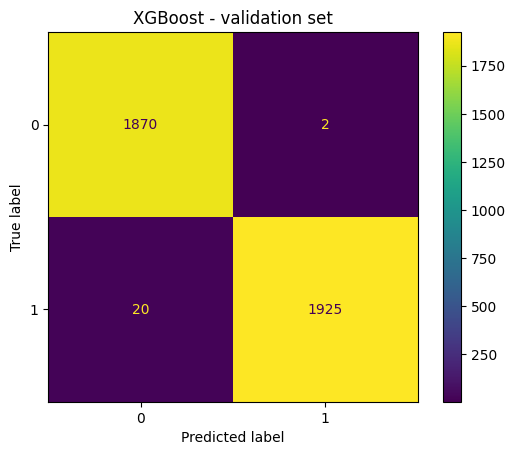

In [34]:
# Compute values for confusion matrix
xgb_cm = confusion_matrix(y_val, y_pred)

# Create display of confusion matrix
xgb_disp = ConfusionMatrixDisplay(confusion_matrix=xgb_cm, display_labels=None)

# Plot confusion matrix
xgb_disp.plot()

# Display plot
plt.title('XGBoost - validation set')
plt.show()


In [35]:
# Create a classification report
target_labels = ['opinion', 'claim']
print(classification_report(y_val, y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1872
       claim       1.00      0.99      0.99      1945

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



From both models, random forest perform slightly better than XGBoost.

So, we going to choose random forest model to predict the tiktok claam status.

### **Use The best model to predict on test data**

In [36]:
# Use champion model to predict on test data
y_pred = rf_cv.best_estimator_.predict(X_test)

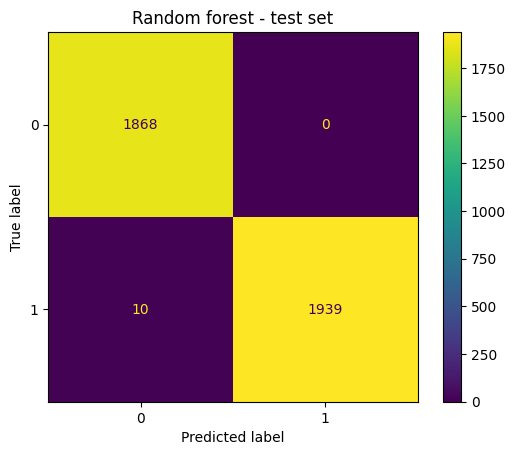

In [37]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

# Plot confusion matrix
log_disp.plot()

# Display plot
plt.title('Random forest - test set');
plt.show()

#### **Feature importances of champion model**



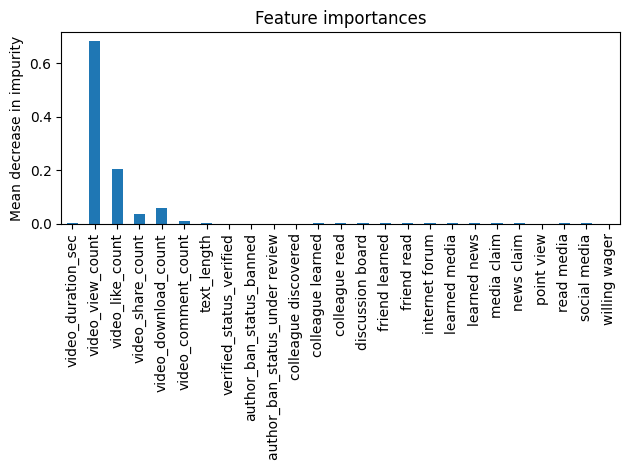

In [38]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()

The most important feature are all related to engagement levels generated by the video.

### Plot the prediction

[Text(0.5, 1.0, 'Tiktok claim status Prediction')]

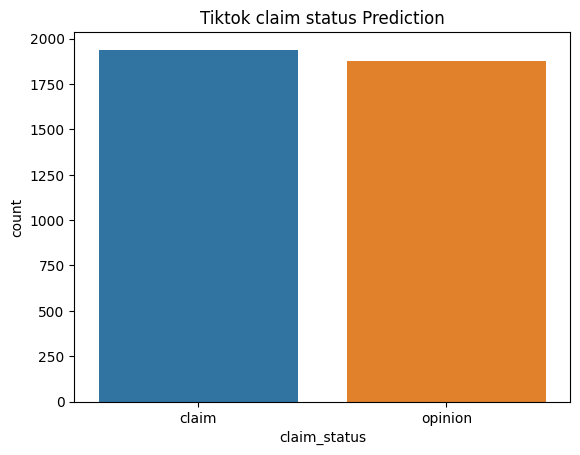

In [39]:
best_model = pd.DataFrame(y_pred.astype('int'),columns=['claim_status'])
sns.countplot(x= best_model['claim_status'].map({ 0:'opinion',  1:'claim'})).set(title='Tiktok claim status Prediction')


Our predict result has nearly the same as dataset which indicates that our model is perform well.